In [2]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.1.1/latest.js?config=TeX-AMS_HTML"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

# Functions

In [4]:
def integrate0(f, xt, dt, _t):
  k1 = dt*f(xt, _t)
  k2 = dt*f(xt+k1/2., _t+dt/2.)
  k3 = dt*f(xt+k2/2., _t+dt/2.)
  k4 = dt*f(xt+k3, _t+dt)
  new_xt = xt + (1/6.)*(k1 + 2.0*k2 + 2.0*k3 + k4)
  return new_xt

def integrate1(f, xt, dt, _t, acc):
  n1, ac = f(xt, _t, acc)
  n2, ac = f(xt+dt*n1/2., _t+dt/2., acc)
  n3, ac = f(xt+dt*n2/2., _t+dt/2., acc)
  n4, ac = f(xt+dt*n3, _t+dt, acc)
  new_xt = xt + (1/6.)*(n1 * dt + 2.0*n2 * dt + 2.0*n3*dt + n4*dt)
  return new_xt, ac

def simulate0(f, x0, tspan, dt, integrate, alpha):
  N = int((max(tspan)-min(tspan))/dt)
  x = np.copy(x0)
  tvec = np.linspace(min(tspan),max(tspan),N)
  xtraj = np.zeros((len(x0),N))
  i = 0
  for i in range(N):
    xtraj[:,i] = integrate(f,[*x],dt, tvec[i])

    if (xtraj[:,i-1][2] > alpha):
      break
    x = np.copy(xtraj[:,i])
  xtraj = np.delete(xtraj, np.s_[i:xtraj.shape[1]], axis=1)
  return xtraj

def transformation(angle, x, y):
  return sym.Matrix([
      [sym.cos(angle), -sym.sin(angle), 0.0, x],
      [sym.sin(angle), sym.cos(angle), 0.0, y],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]
  ])

def unhat(m):
  return sym.Matrix([m[0,3], m[1,3], m[2,3], m[2,1], m[0,2], m[1,0]])

def inverse(m):
  R = sym.Matrix([
      [m[0,0], m[0,1], m[0,2]],
      [m[1,0], m[1,1], m[1,2]],
      [m[2,0], m[2,1], m[2,2]]
  ]).T

  v = -R * sym.Matrix([m[0,3], m[1,3], m[2,3]])
  return sym.Matrix([
      [R[0,0], R[0,1], R[0,2], v[0]],
      [R[1,0], R[1,1], R[1,2], v[1]],
      [R[2,0], R[2,1], R[2,2], v[2]],
      [0,0,0,1]
  ])

# Defining System Variables

In [5]:
# Length of human arm and torso
L = [0.762, 1.3208]
# Width of human arm and torso
W = [0.1016, 0.1778]
# Mass of human arm and torso
m = [5.4, 60]
J = 1
# Gymnastics high bar is 2.8m high
h = 2.8
# Constant acceleration due to gravity
g = 9.8

In [6]:
t = sym.symbols("t")
theta1 = sym.Function("theta_1")(t)
theta2 = sym.Function("theta_2")(t)
x = sym.Function("x")(t)
y = sym.Function("y")(t)

q = sym.Matrix([x, y, theta1, theta2])
qdot = q.diff(t)
qddot = qdot.diff(t)

# Transformations

In [7]:
# Define transformations
g_wa = transformation(0, q[0], q[1])
g_wb = g_wa * transformation(theta1, 0, 0) * transformation(0, 0, L[0]/2)
g_wc = g_wb * transformation(0, 0, L[0]/2)
g_wd = g_wc * transformation(theta2, 0, 0) * transformation(0, 0, L[1]/2)

# Corners of D
g_we = g_wd * transformation(0, -W[1]/2, L[1]/2)
g_wf = g_wd * transformation(0, W[1]/2, L[1]/2)
g_wg = g_wd * transformation(0, -W[1]/2, -L[1]/2)
g_wh = g_wd * transformation(0, W[1]/2, -L[1]/2)

# Corners of B
g_wi = g_wb * transformation(0, -W[0]/2, L[0]/2)
g_wj = g_wb * transformation(0, W[0]/2, L[0]/2)
g_wk = g_wb * transformation(0, -W[0]/2, -L[0]/2)
g_wl = g_wb * transformation(0, W[0]/2, -L[0]/2)

In [8]:
# Inertia matrix
I_0 = sym.Matrix([
    [m[0], 0, 0, 0, 0, 0],
    [0, m[0], 0, 0, 0, 0],
    [0, 0, m[0], 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, J]
]) 

I_1 = sym.Matrix([
    [m[1], 0, 0, 0, 0, 0],
    [0, m[1], 0, 0, 0, 0],
    [0, 0, m[1], 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, J]
]) 

# Lagrangian

In [9]:
# Body velocities
V_0 = unhat(inverse(g_wb)*g_wb.diff(t))
V_1 = unhat(inverse(g_wd)*g_wd.diff(t))

In [10]:
# Kinetic energy
KE_0 = 0.5 * (V_0.T * I_0 * V_0)[0]
KE_1 = 0.5 * (V_1.T * I_1 * V_1)[0]

In [11]:
# Potential energy
PE_0 = m[0] * g * (g_wb * sym.Matrix([0,0,0,1]))[1]
PE_1 = m[1] * g * (g_wd * sym.Matrix([0,0,0,1]))[1]

In [12]:
# Lagrangian
Lagrangian = sym.simplify((KE_0 + KE_1) - (PE_0 + PE_1))

# Phase One Euler-Lagrange

In [13]:
# Constraints
phi0 = (g_wa * sym.Matrix([0,0,0,1]))[0] 
phi1 = (g_wa * sym.Matrix([0,0,0,1]))[1] - h
phi = sym.Matrix([phi0, phi1])
lamb0, lamb1 = sym.symbols("lambda_0, lambda_1")
lamb = sym.Matrix([lamb0, lamb1])

In [14]:
# External forces
F = sym.Matrix([4,4, 0, 0])

In [15]:
# Euler-Lagrange Eq
ELEQ0 = sym.Eq(Lagrangian.diff(qdot).diff(t) - Lagrangian.diff(q), phi0.diff(q) * lamb0 + phi1.diff(q) * lamb1 + F)
phi0_EQ = sym.Eq(0, phi0.diff(t).diff(t))
phi1_EQ = sym.Eq(0, phi1.diff(t).diff(t))

In [16]:
sol0 = sym.solve([ELEQ0,phi0_EQ, phi1_EQ], [*qddot, *lamb])

In [17]:
# Lambdify
sol_x = sym.lambdify([*q, *qdot], sol0[qddot[0]])
sol_y = sym.lambdify([*q, *qdot], sol0[qddot[1]])
sol_theta1 = sym.lambdify([*q, *qdot], sol0[qddot[2]])
sol_theta2 = sym.lambdify([*q, *qdot], sol0[qddot[3]])

In [18]:
def dyn0(s, t):
  return np.array([s[4], s[5], s[6], s[7], 
                   sol_x(*s), sol_y(*s), sol_theta1(*s), sol_theta2(*s)])

# Animation Code

In [94]:
g_wj_x = sym.lambdify([*q, *qdot], ((g_wj * sym.Matrix([0,0,0,1]))[0]))
g_wj_y = sym.lambdify([*q, *qdot], ((g_wj * sym.Matrix([0,0,0,1]))[1]))
g_wi_x = sym.lambdify([*q, *qdot], ((g_wi * sym.Matrix([0,0,0,1]))[0]))
g_wi_y = sym.lambdify([*q, *qdot], ((g_wi * sym.Matrix([0,0,0,1]))[1]))
g_wk_x = sym.lambdify([*q, *qdot], ((g_wk * sym.Matrix([0,0,0,1]))[0]))
g_wk_y = sym.lambdify([*q, *qdot], ((g_wk * sym.Matrix([0,0,0,1]))[1]))
g_wl_x = sym.lambdify([*q, *qdot], ((g_wl * sym.Matrix([0,0,0,1]))[0]))
g_wl_y = sym.lambdify([*q, *qdot], ((g_wl * sym.Matrix([0,0,0,1]))[1]))
g_wf_x = sym.lambdify([*q, *qdot], ((g_wf * sym.Matrix([0,0,0,1]))[0]))
g_wf_y = sym.lambdify([*q, *qdot], ((g_wf * sym.Matrix([0,0,0,1]))[1]))
g_wk_x = sym.lambdify([*q, *qdot], ((g_wk * sym.Matrix([0,0,0,1]))[0]))
g_wk_y = sym.lambdify([*q, *qdot], ((g_wk * sym.Matrix([0,0,0,1]))[1]))
g_we_x = sym.lambdify([*q, *qdot], ((g_we * sym.Matrix([0,0,0,1]))[0]))
g_we_y = sym.lambdify([*q, *qdot], ((g_we * sym.Matrix([0,0,0,1]))[1]))
g_wg_x = sym.lambdify([*q, *qdot], ((g_wg * sym.Matrix([0,0,0,1]))[0]))
g_wg_y = sym.lambdify([*q, *qdot], ((g_wg * sym.Matrix([0,0,0,1]))[1]))
g_wh_x = sym.lambdify([*q, *qdot], ((g_wh * sym.Matrix([0,0,0,1]))[0]))
g_wh_y = sym.lambdify([*q, *qdot], ((g_wh * sym.Matrix([0,0,0,1]))[1]))

def animate(animation_1, animation_2, L, W, T=10):
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    N1 = len(animation_1[0])//100
    N2 = len(animation_2[0])
    N = N1 + N2
    b_1_x = np.zeros(N)
    b_1_y = np.zeros(N)
    b_2_x = np.zeros(N)
    b_2_y = np.zeros(N)
    b_3_x = np.zeros(N)
    b_3_y = np.zeros(N)
    b_4_x = np.zeros(N)
    b_4_y = np.zeros(N)

    c_1_x = np.zeros(N)
    c_1_y = np.zeros(N)
    c_2_x = np.zeros(N)
    c_2_y = np.zeros(N)
    c_3_x = np.zeros(N)
    c_3_y = np.zeros(N)
    c_4_x = np.zeros(N)
    c_4_y = np.zeros(N)
    var = 0

    input_arr = animation_1
    for t in range(N1): # iteration through each time step
        b_1_x[t] = g_wj_x(*input_arr.T[var])
        b_1_y[t] = g_wj_y(*input_arr.T[var])
        b_2_x[t] = g_wi_x(*input_arr.T[var])
        b_2_y[t] = g_wi_y(*input_arr.T[var])
        b_3_x[t] = g_wk_x(*input_arr.T[var])
        b_3_y[t] = g_wk_y(*input_arr.T[var])
        b_4_x[t] = g_wl_x(*input_arr.T[var])
        b_4_y[t] = g_wl_y(*input_arr.T[var])
        c_1_x[t] = g_wf_x(*input_arr.T[var])
        c_1_y[t] = g_wf_y(*input_arr.T[var])
        c_2_x[t] = g_we_x(*input_arr.T[var])
        c_2_y[t] = g_we_y(*input_arr.T[var])
        c_3_x[t] = g_wg_x(*input_arr.T[var])
        c_3_y[t] = g_wg_y(*input_arr.T[var])
        c_4_x[t] = g_wh_x(*input_arr.T[var])
        c_4_y[t] = g_wh_y(*input_arr.T[var])
        var +=100
    var = 0
    input_arr = animation_2

    for t in range(N1, N): # iteration through each time step
        b_1_x[t] = g_wj_x(*input_arr.T[var])
        b_1_y[t] = g_wj_y(*input_arr.T[var])
        b_2_x[t] = g_wi_x(*input_arr.T[var])
        b_2_y[t] = g_wi_y(*input_arr.T[var])
        b_3_x[t] = g_wk_x(*input_arr.T[var])
        b_3_y[t] = g_wk_y(*input_arr.T[var])
        b_4_x[t] = g_wl_x(*input_arr.T[var])
        b_4_y[t] = g_wl_y(*input_arr.T[var])
        c_1_x[t] = g_wf_x(*input_arr.T[var])
        c_1_y[t] = g_wf_y(*input_arr.T[var])
        c_2_x[t] = g_we_x(*input_arr.T[var])
        c_2_y[t] = g_we_y(*input_arr.T[var])
        c_3_x[t] = g_wg_x(*input_arr.T[var])
        c_3_y[t] = g_wg_y(*input_arr.T[var])
        c_4_x[t] = g_wh_x(*input_arr.T[var])
        c_4_y[t] = g_wh_y(*input_arr.T[var])
        var += 1

    xm = -2 #np.min(xx1)-0.5
    xM = 10 #np.max(xx1)+0.5
    ym = 0 #np.min(yy1)-2.5
    yM = 6 #np.max(yy1)+1.5

    data=[

        dict(name='B'),
        dict(name='C'),
        dict(x=[xm, xM], y=[0,0], mode="lines", name="Ground", line=dict(color="green",width=4)),]

    layout=dict(autosize=False, width=1000, height=800,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Gymnastics High Bar Dismount Simulator', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    frames=[
        dict(data=[
            dict(x=[b_1_x[k],
                    b_2_x[k],
                    b_3_x[k],
                    b_4_x[k],
                    b_1_x[k]],
                 y=[b_1_y[k],
                    b_2_y[k],
                    b_3_y[k],
                    b_4_y[k],
                    b_1_y[k]],
                 mode="lines",
                 line=dict(color="red",width=4,),),                 
                 
            dict(x=[c_1_x[k],
                    c_2_x[k],
                    c_3_x[k],
                    c_4_x[k],
                    c_1_x[k]],
                 y=[c_1_y[k],
                    c_2_y[k],
                    c_3_y[k],
                    c_4_y[k],
                    c_1_y[k]],
                 mode="lines",
                 line=dict(color="blue",width=4,),)
        
          ]) for k in range(N)
      ]

    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

# Phase Two Impacts

In [20]:
phi_impact0 = (g_we * sym.Matrix([0,0,0,1]))[1]-0.0
phi_impact1 = (g_wf * sym.Matrix([0,0,0,1]))[1]-0.0
dphi_impact0 = phi_impact0.diff(q)
dphi_impact1 = phi_impact1.diff(q)
dLdqdot = sym.Matrix([Lagrangian]).jacobian(qdot)

In [21]:
temp = list(sym.symbols(r'x, y, \theta_1, \theta_2, \dot{x}, \dot{y}, \dot{\theta_1}, \dot{\theta_2}, \ddot{x}, \ddot{y}, \ddot{\theta_1}, \ddot{\theta_2}'))
dummy_sub = dict(zip([*q, *qdot, *qddot], [*temp]))

dLdqdot_dummy = sym.simplify(dLdqdot.subs(dummy_sub))
#H_dummy = sym.simplify(H.subs(dummy_sub))
dphi_impact0_dummy = sym.simplify(dphi_impact0.subs(dummy_sub))
dphi_impact1_dummy = sym.simplify(dphi_impact1.subs(dummy_sub))
phi_impact0_dummy = sym.simplify(phi_impact0.subs(dummy_sub))
phi_impact1_dummy = sym.simplify(phi_impact1.subs(dummy_sub))

In [22]:
temp_plus = list(sym.symbols(r"\dot{x}^{+}, \dot{y}^{+}, \dot{\theta_1}^{+}, \dot{\theta_2}^{+}"))
lamb0, lamb1 = sym.symbols(r"\lambda_0, \lambda_1")
dLdqdot_dummy_plus = dLdqdot_dummy.subs(dict(zip([*temp[4:8]], [*temp_plus])))
#H_dummy_plus = H_dummy.subs(dict(zip([*temp[4:8]], [*temp_plus])))

impact_eq0 = sym.Eq(dLdqdot_dummy_plus - dLdqdot_dummy, dphi_impact0_dummy.T * lamb0)
impact_eq1 = sym.Eq(dLdqdot_dummy_plus - dLdqdot_dummy, dphi_impact1_dummy.T * lamb1)
#impact_eq_ham = sym.Eq(H_dummy_plus[0] - H_dummy[0], 0)
impact_plastic_eq0 = sym.Eq(0, (dphi_impact0_dummy.T * qdot.subs(dummy_sub))[0])
impact_plastic_eq1 = sym.Eq(0, (dphi_impact1_dummy.T * qdot.subs(dummy_sub))[0])

impact_eq0 = sym.simplify(impact_eq0)
impact_eq1 = sym.simplify(impact_eq1)
impact_plastic_eq0 = sym.simplify(impact_plastic_eq0.subs(dict(zip([*temp[4:8]], [*temp_plus]))))
impact_plastic_eq1 = sym.simplify(impact_plastic_eq1.subs(dict(zip([*temp[4:8]], [*temp_plus]))))


#impact_eq_ham = sym.simplify(impact_eq_ham)

In [23]:
def impact_update(s, impact_eq, lamb, plastic):
  impact = impact_eq.subs(dict(zip([*temp[0:8]], [*s])))
  #ham = impact_eq_ham.subs(dict(zip([*temp[0:8]], [*s])))
  impact_plastic = plastic.subs(dict(zip([*temp[0:8]], [*s])))

  impact_sols = sym.solve([impact, impact_plastic], [*temp_plus, lamb],dict=True)

  # if (len(impact_sols) == 1):
  #   # Invalid
  #   return np.array([]) 

  for sol in impact_sols:
    if not (abs(sol[lamb]) < 1e-5):
      return np.array([s[0], s[1], s[2], s[3], float(sym.N(sol[temp_plus[0]])), float(sym.N(sol[temp_plus[1]])), float(sym.N(sol[temp_plus[2]])), float(sym.N(sol[temp_plus[3]]))]) 


In [24]:
phi0_sol = sym.lambdify([*q, *qdot], phi_impact0)
phi1_sol = sym.lambdify([*q, *qdot], phi_impact1)

In [25]:
def impact_condition(s, phi_in):
  if(phi_in(*s) < 0):
    return True
  return False

# Phase Two Euler-Lagrange

In [26]:
ELEQ1 = sym.Eq(Lagrangian.diff(qdot).diff(t), Lagrangian.diff(q))
ddtemp = list(sym.symbols('a,b,c,d'))
ELEQ1_subs = ELEQ1.subs(dict(zip([*qddot], [*ddtemp])))

In [27]:
# Impact
def simulate1(f, x0, tspan, dt, integrate):
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))

    sol1 = sym.solve([ELEQ1_subs.subs(dict(zip([*q, *qdot], [*x0])))], [*ddtemp])
    acc = sol1.values()
    i = 0
    for i in range(N):

      if impact_condition(x, phi0_sol) == True and impact_condition(x, phi1_sol) == True:
        print("Stuck the Landing")
        break

      if impact_condition(x, phi0_sol) == True:
        x = impact_update(np.copy(xtraj[:,i-1]), impact_eq0, lamb0, impact_plastic_eq0)
      
      elif impact_condition(x, phi1_sol) == True:
        x = impact_update(np.copy(xtraj[:,i-1]), impact_eq1, lamb1, impact_plastic_eq1)

      xtraj[:,i], acc = integrate(f,x,dt, tvec[i], acc)
      x = np.copy(xtraj[:,i])

    xtraj = np.delete(xtraj, np.s_[i-1:xtraj.shape[1]], axis=1)
    return xtraj

In [28]:
def dyn1(s, t, acc):
  print(t)
  sol1 = sym.nsolve([ELEQ1_subs.subs(dict(zip([*q, *qdot], [*s])))], [*ddtemp], [*acc])
  acc = sol1.values()
  return np.array([s[4], s[5], s[6], s[7], 
                   sol1[0], sol1[1], sol1[2], sol1[3]]), acc

# Angle Configuration and Simulate

In [286]:
# Configure release angle
alpha = 36
alpha = np.deg2rad(alpha) + np.pi

In [287]:
# x, y, theta1, theta2
s0 = [0.0, h, 0.0, 0.0, 0.0, 0.0, 0.6, 1.6]
traj0 = simulate0(dyn0, s0, [0,10], 0.0001, integrate0, alpha)

In [288]:
# plt.figure()
# plt.plot(traj0[0:4].T)
# plt.legend(["x(t)", "y(t)", r'$\theta_1(t)$', r'$\theta_2(t)$'])
# plt.title("Trajectories vs. Time Step")
# plt.show()

In [289]:
s1 = traj0.T[-1]
print("Actual Release Angle", s1[2]*180/np.pi - 180)

Actual Release Angle 36.0121475175207


In [290]:
traj1 = simulate1(dyn1, s1, [0,1.5], 0.01, integrate1)


0.0
0.005
0.005
0.01
0.010067114093959731
0.015067114093959732
0.015067114093959732
0.020067114093959733
0.020134228187919462
0.025134228187919463
0.025134228187919463
0.030134228187919464
0.030201342281879193
0.03520134228187919
0.03520134228187919
0.040201342281879195
0.040268456375838924
0.04526845637583892
0.04526845637583892
0.050268456375838926
0.050335570469798654
0.05533557046979865
0.05533557046979865
0.060335570469798656
0.060402684563758385
0.06540268456375839
0.06540268456375839
0.07040268456375838
0.07046979865771812
0.07546979865771812
0.07546979865771812
0.08046979865771811
0.08053691275167785
0.08553691275167785
0.08553691275167785
0.09053691275167784
0.09060402684563758
0.09560402684563758
0.09560402684563758
0.10060402684563757
0.10067114093959731
0.10567114093959731
0.10567114093959731
0.1106711409395973
0.11073825503355704
0.11573825503355704
0.11573825503355704
0.12073825503355703
0.12080536912751677
0.12580536912751678
0.12580536912751678
0.13080536912751678
0.130

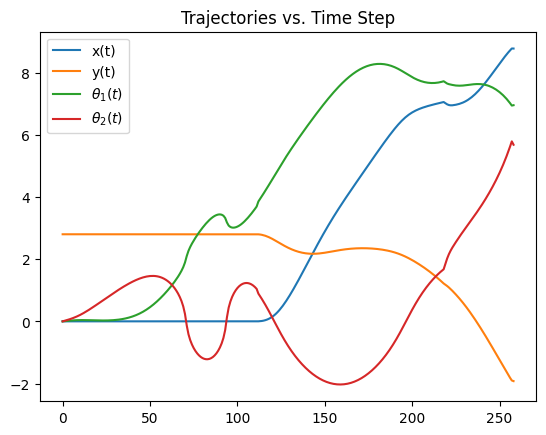

In [291]:
plt.figure()
plt.plot(np.concatenate((traj0[0:4,0::100].T, traj1[0:4].T)))
plt.legend(["x(t)", "y(t)", r'$\theta_1(t)$', r'$\theta_2(t)$'])
plt.title("Trajectories vs. Time Step")
plt.show()

# Animation

In [296]:
print(traj0.shape)
print(traj1.shape)
animate(traj0, traj1[0:8,:-38], L, W)
# Reload this box if the animation doesn't appear

Output hidden; open in https://colab.research.google.com to view.